This notbook is inspired on Andrej Karpathy's youtube lecture about micrograd. Available on https://www.youtube.com/watch?v=VMj-3S1tku0&t=5128s 

In [33]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
# This is a data structre that will maintain these expressions in neural newtworks with its expressions
class Value:

    def __init__(self, data, _children = (), _op = '', label = ''):
        self.data = data
        self._prev = set(_children) # Children are supposed to be tuples. _prev represents the previous value before the last operation
        self.grad = 0 # The derivative, which starts at 0. As a derivative of 0 means that there is no change
        self._op = _op # Operation symbol
        self.label = label
        self._backward = lambda: None

    def __repr__(self):
        return f"Value(data = {self.data})"
    
    def __add__(self, other):
        # Defining these operators with these __xxx__
        other = other if isinstance(other, Value) else Value(other) # If it is an instance of value, we'll wrap in the value. This way we can add numbers a + 2
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1 * out.grad # It's a 1 as this is a plus operation
            other.grad += 1 * out.grad
        out._backward = _backward

        return out
    
    def __sub__(self, other):
        # This is needed for the rest of the operations to recognize the "-" signal
        other = other if isinstance(other, Value) else Value(other) # If it is an instance of value, we'll wrap in the value. This way we can sub numbers a - 2
        out = Value(self.data - other.data, (self, other), '-')

        def _backward():
            self.grad += 1 * out.grad # It's a 1 as this is a plus operation
            other.grad += -1 * out.grad
        out._backward = _backward

        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other) # If it is an instance of value, we'll wrap in the value. This way we can multiply numbers like a * 2
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad # Chain rule
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad # d(exp)/dx = x * e ** (x-1)
        out._backward = _backward

        return out


    def __rmul__(self, other): # other * self # This way we can multiply 2 * a instead of just 2 * a
        return self * other

    def __truediv__(self, other): # self / other #  Division is the same thing as multiplying by a -1 exponential
        return self * other**-1
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1) # t is tanh
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1-t**2) * out.grad # Chain rule
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad 
        out._backward = _backward
    
        return out
    
    def backward(self):
        topo = []
        visited = set() # visited nodes
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev: # iterates through all the children of the node
                    build_topo(child)
                topo.append(v) # It only adds the node itself after going through all the children

        build_topo(self)

        self.grad = 1
        # This makes what we did manually, going from O to the beginning
        for node in reversed(topo):
            node._backward()    

In [35]:
import graphviz 
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % ( n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [36]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

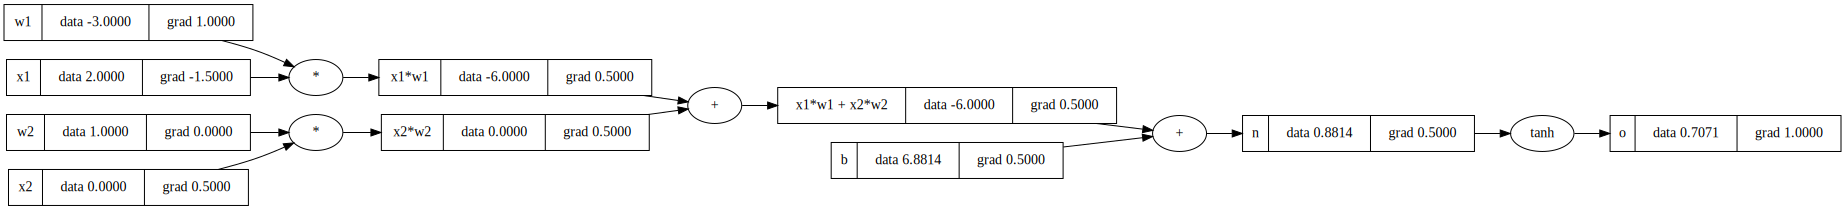

In [37]:
draw_dot(o)

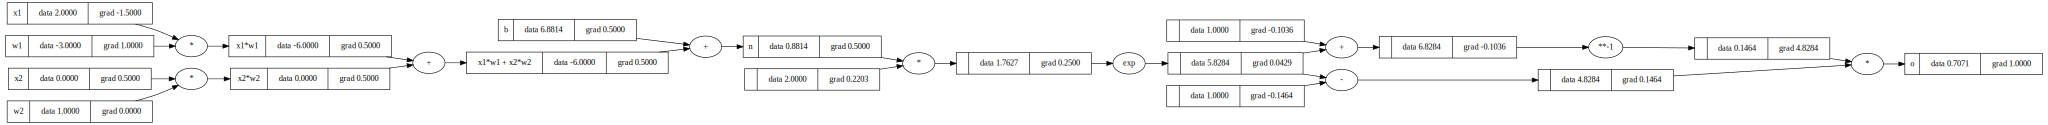

In [38]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [39]:
import torch

In [40]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True # By casting to double python converts it into float
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True # Typically you don't need the gras in leaf nodes as it is not as efficient doing this way
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [41]:
o.item()

0.7071066904050358

In [42]:
x2.grad.item() # Torch has the backward pass that calculates the gradient as it was done manually

0.5000001283844369

In [43]:
# Building a neuron class

class Neuron: 
    def __init__(self, nin): #n_instances
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)] # A neuron has the weights and the bias
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # W * x +b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) # act is short for activation
        out = act.tanh()
        return out
    


In [44]:
# A single neuron
x = [2,3]
n = Neuron(2)
n(x)

Value(data = 0.19665461629834508)

A list of neurons, a Layer

In [45]:
class Layer:
    def __init__(self, nin, nout) -> None:
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) ==1 else outs # This allows to just get a single value out in the final layer that only has 1 neuron

In [46]:
x = [2, 3]
n = Layer(2, 3)
n(x)

[Value(data = 0.9889301744430593),
 Value(data = 0.9896885271312302),
 Value(data = -0.5691472595846252)]

A list of Layers, a multi layer perceptron, MLP

In [47]:
class MLP:
  
  def __init__(self, nin, nouts): # number of inputs, number of outputs. The nouts is a list, which represent the sizes of the layers
    sz = [nin] + nouts # This is to create the sizes of the layers as it will be a list
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))] # Each layer receives the number of inputs and outputs. Iterates in pairs
  
  def __call__(self, x): # This just calls them sequentially
    for layer in self.layers:
      x = layer(x)
    return x

In [48]:
x = [2, 3, -1]
n = MLP(3, [4,4,1]) # 3 neurons in the  input layer, 4 neurons in the output layers and 1 neuron in the output layer
n(x)

Value(data = 0.9344277913234812)

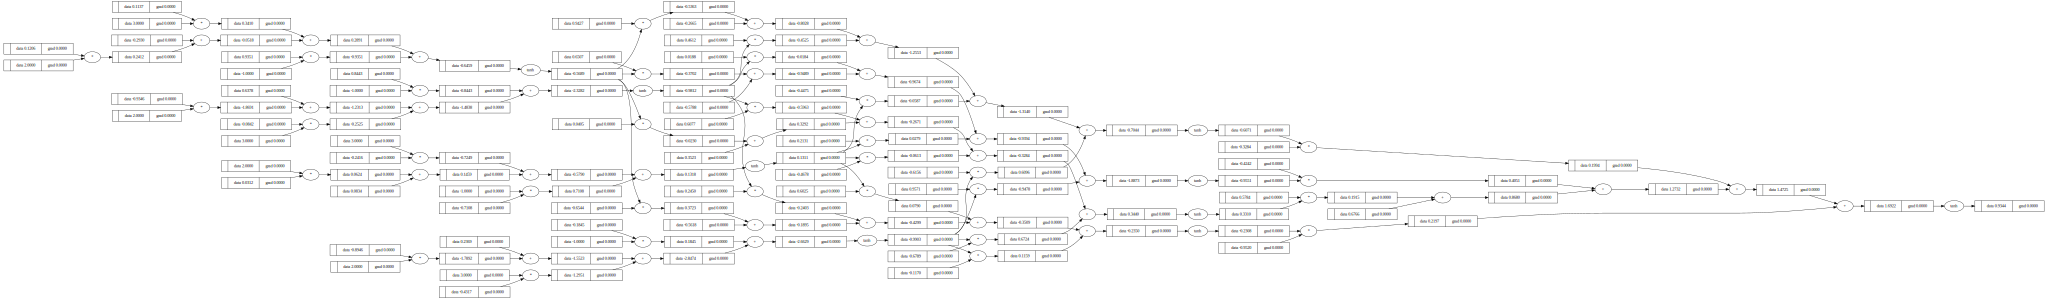

In [49]:
draw_dot(n(x))

Basic classifier neural net

In [75]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [76]:
ypred = [n(x) for x in xs]
ypred # This has no training

[Value(data = 0.9344277913234812),
 Value(data = 0.9539024225234004),
 Value(data = 0.9645964343441317),
 Value(data = 0.8480013110344912)]

In [77]:
# Loss measures how well the neural net is performing
# MSE loss: The squared makes sure that whether it is negative or positive, it always gets a positive number
# Initialize the loss with a zero Value object
loss = Value(0.0)

# Perform the summation
for ygt, yout in zip(ys, ypred): # ygt: y ground truth
    loss += (yout - ygt)**2 
    
loss

Value(data = 7.704777142578439)

In [78]:
loss.backward()

In [100]:
n.layers[0].neurons[0].w

[Value(data = 0.12058012372348115),
 Value(data = 0.11365560509522332),
 Value(data = 0.9350796496081504)]

In [79]:
n.layers[0].neurons[0].w[0].grad # First weight of the first neuron of the the first layer

-177.2103252866385

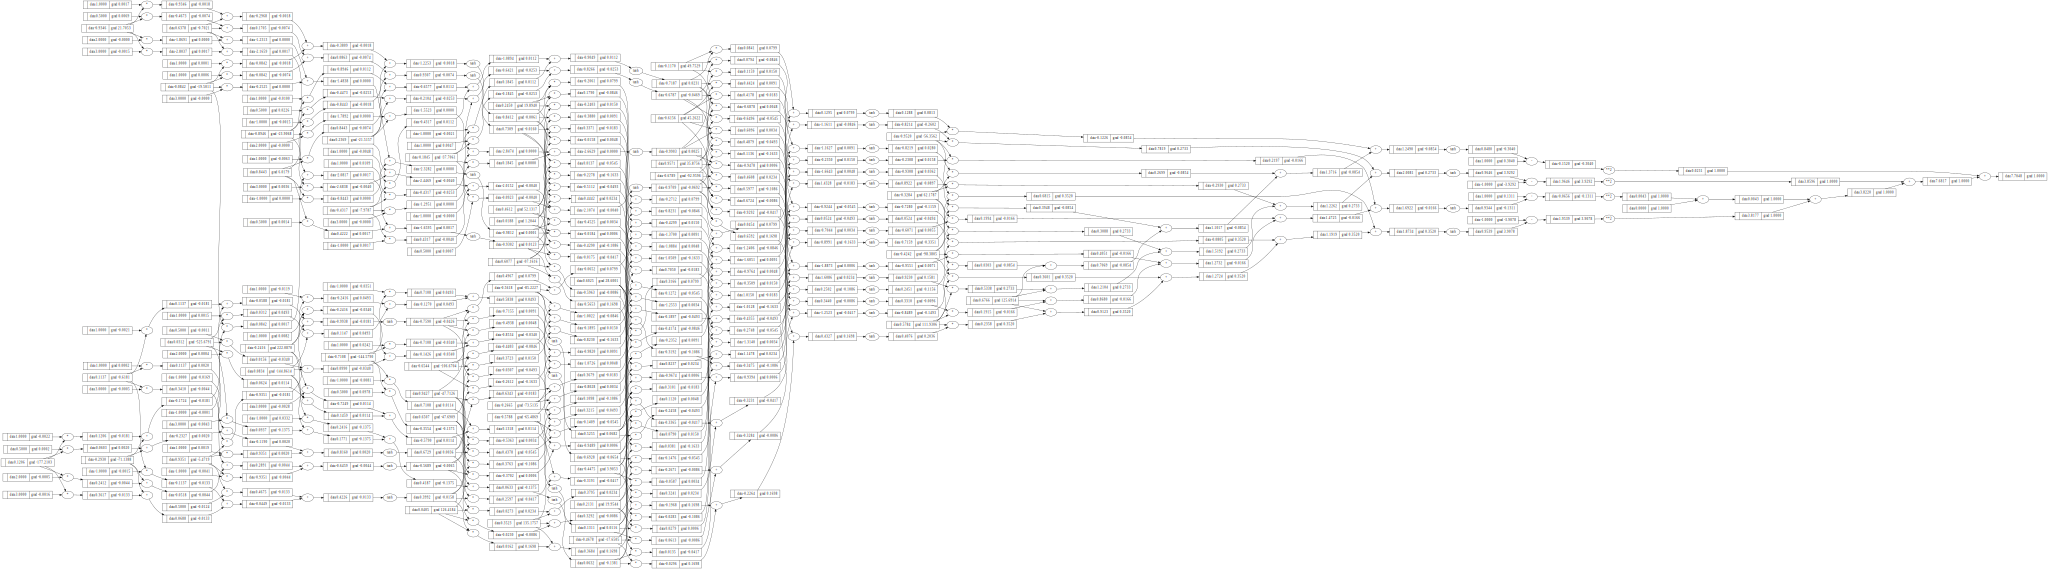

In [81]:
draw_dot(loss)